<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Quickstart: Web Cam Image Classification


Image classification is the canonical computer vision task of determining if an image contains a specific object, feature, or activity. Currently, the best models are based on [convolutional neural networks (CNNs)](https://en.wikipedia.org/wiki/Convolutional_neural_network) and are typically pre-trained on [ImageNet dataset](http://www.image-net.org/). The CNN weights are trained on millions of images and hundreds of object classes.  Implementations are available from many deep neural network frameworks including [CNTK](https://www.microsoft.com/en-us/cognitive-toolkit/features/model-gallery/), [fast.ai](https://docs.fast.ai/vision.models.html#Computer-Vision-models-zoo), [Keras](https://keras.io/applications/), [PyTorch](https://pytorch.org/docs/stable/torchvision/models.html), and [TensorFlow](https://tfhub.dev/s?module-type=image-classification).

This notebook shows a simple example of loading a pretrained model to score a webcam stream. Here, we use a [ResNet](https://arxiv.org/abs/1512.03385) model using the `fastai.vision` package.

For more details about image classification tasks, including transfer learning, please see our [training introduction notebook](01_training_introduction.ipynb).

## Prerequisite for Webcam example 
This notebook assumes you have **a webcam** connected to your machine. If you want to use a remote-VM to run the model and codes while using a local machine for the webcam stream, you can use an SSH tunnel:
1. SSH connect to your VM
    ```
    $ ssh -L 8888:localhost:8888 <user-id@url-to-your-vm>
    ```
2. Launch a Jupyter session on the VM (with port 8888 which is the default)
3. Open `localhost:8888` from your browser on the webcam connected local machine to access the Jupyter notebook running on the VM.

We use the `ipywebrtc` module to show the webcam widget in the notebook. Currently, the widget works on **Chrome** and **Firefox**. For more details about the widget, please visit `ipywebrtc` [github](https://github.com/maartenbreddels/ipywebrtc) or [documentation](https://ipywebrtc.readthedocs.io/en/latest/).

## Initialization

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import sys
sys.path.append("../../")
import io
import os
import time
import urllib.request

import fastai
from fastai.vision import models, open_image
from ipywebrtc import CameraStream, ImageRecorder
from ipywidgets import HBox, Label, Layout, Widget
import scrapbook as sb

from utils_cv.common.data import data_path
from utils_cv.common.gpu import which_processor
from utils_cv.classification.data import imagenet_labels
from utils_cv.classification.model import IMAGENET_IM_SIZE, model_to_learner

print(f"Fast.ai: {fastai.__version__}")
which_processor()

Fast.ai: 1.0.57
Torch is using GPU: Tesla V100-PCIE-16GB


# Load Pretrained Model

To introduce the computer vision approach with CNNs, we will start with a pretrained `ResNet18` CNN which is a relatively small and fast CNNs architecture. The [reported error rate](https://pytorch.org/docs/stable/torchvision/models.html) of the model on ImageNet is 30.24% for top-1 and 10.92% for top-5 (top n labels considered most probable by the model).

This model expects RGB-images as input. To take advantage of the pretrained ResNet model that was trained on imagenet, we need to _normalize_ our image data in the same way. This includes reducing the range of values of RGB from 0-255 to 0-1 and using the normalization mean and std which can be found in [`fastai.vision.imagenet_stats`](https://github.com/fastai/fastai/blob/master/fastai/vision/data.py#L78).

The output of the model is a probability distribution of the labeled classes in ImageNet. To convert them into human-readable labels, we utilize the label json file from [Keras](https://github.com/keras-team/keras/blob/master/keras/applications/imagenet_utils.py).

**Note:** You can load a different model using `learn = load_learner(path)`. To learn more about model-export and load, see the [fastai doc](https://docs.fast.ai/basic_train.html#Deploying-your-model).

In [3]:
labels = imagenet_labels()
print(f"Num labels = {len(labels)}")
print(f"{', '.join(labels[:5])}, ...")

Num labels = 1000
tench, goldfish, great_white_shark, tiger_shark, hammerhead, ...


Following fast.ai's naming conventions:  A [`Learner`](https://docs.fast.ai/basic_train.html#Learner) is a `Trainer` for `model` using `data` to minimize `loss_func` with optimizer `opt_func`.

In [4]:
# Convert a pretrained imagenet model into Learner for prediction. 
# You can load an exported model by learn = load_learner(path) as well.
learn = model_to_learner(models.resnet18(pretrained=True), IMAGENET_IM_SIZE)

# Classify Images

## Image file
First, we prepare a coffee mug image to show an example of how to score a single image by using the model.

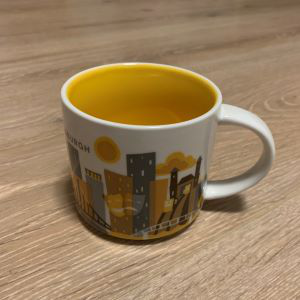

In [5]:
# Download an example image
IM_URL = "https://cvbp-secondary.z19.web.core.windows.net/images/cvbp_cup.jpg"
urllib.request.urlretrieve(IM_URL, os.path.join(data_path(), "example.jpg"))

im = open_image(os.path.join(data_path(), "example.jpg"), convert_mode='RGB')
im

Using the `learn.predict` method, we ask the model to classify this image. The model classifies the image returning the label with the highest probability score. In this case, "coffee_mug".

In [6]:
start_time = time.time()

# Use the model to predict the class label
_, ind, prob = learn.predict(im)
predicted_label = labels[ind]
predicted_confidence = prob[ind]
print(f"Predicted label: {predicted_label} (confidence = {predicted_confidence:.2f})")

# Show prediction time. Note the first prediction usually takes longer because of the model loading
print(f"Took {time.time()-start_time} sec")

Predicted label: coffee_mug (confidence = 0.68)
Took 0.02240896224975586 sec


## WebCam Stream

Now, we use a WebCam stream for image classification. We use `ipywebrtc` to start a webcam and get the video stream which is sent to the notebook's widget. Note that Jupyter widgets are quite unstable - if the widget below does not show then see the "Troubleshooting" section in this [FAQ](./FAQ.md) for possible fixes. 

In [7]:
# Webcam
w_cam = CameraStream(
    constraints={
        'facing_mode': 'user',
        'audio': False,
        'video': { 'width': IMAGENET_IM_SIZE, 'height': IMAGENET_IM_SIZE }
    },
    layout=Layout(width=f'{IMAGENET_IM_SIZE}px')
)
# Image recorder for taking a snapshot
w_imrecorder = ImageRecorder(stream=w_cam, layout=Layout(padding='0 0 0 50px'))
# Label widget to show our classification results
w_label = Label(layout=Layout(padding='0 0 0 50px'))

def classify_frame(_):
    """ Classify an image snapshot by using a pretrained model
    """
    # Once capturing started, remove the capture widget since we don't need it anymore
    if w_imrecorder.layout.display != 'none':
        w_imrecorder.layout.display = 'none'
        
    try:
        im = open_image(io.BytesIO(w_imrecorder.image.value), convert_mode='RGB')
        _, ind, prob = learn.predict(im)
        # Show result label and confidence
        w_label.value = f"{labels[ind]} ({prob[ind]:.2f})"
    except OSError:
        # If im_recorder doesn't have valid image data, skip it. 
        pass
    
    # Taking the next snapshot programmatically
    w_imrecorder.recording = True

# Register classify_frame as a callback. Will be called whenever image.value changes. 
w_imrecorder.image.observe(classify_frame, 'value')

In [8]:
# Show widgets
HBox([w_cam, w_imrecorder, w_label])

Now, click the **capture button** in the widget to start classification. Labels are displayed to show the most probable class along with the confidence predicted by the model for an image snapshot.

<img src="https://cvbp-secondary.z19.web.core.windows.net/images/cvbp_webcam.png" width="400" />
<center>
<i>Example Webcam image</i>
</center>

# Conclusion
In this notebook, we used a simple example to demonstrate how to use a pretrained model to classify images. The model is limited to only predict object labels that are part of the ImageNet training samples. From our [training introduction notebook](01_training_introduction.ipynb), you can find how to fine-tune a model to customize the model to detect other objects that you may be interested in finding.

In [9]:
# Stop the model and webcam
Widget.close_all()

In [10]:
# Preserve some of the notebook outputs
sb.glue("predicted_label", predicted_label)
sb.glue("predicted_confidence", float(predicted_confidence))